## <font color="chillipepper">**Imports and Data Prep**</font>

In [19]:
import numpy as np
import pandas as pd

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna

import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
def rmspe_metric(y_true, y_pred):
    
    """Root Mean Square Percentage Error Metric"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))

In [21]:
path = "data\\Rossmann_Sales.csv"
data = pd.read_csv(path, low_memory=False)

data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842936 entries, 0 to 842935
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       842936 non-null  int64         
 1   DayOfWeek                   842936 non-null  int64         
 2   Date                        842936 non-null  datetime64[ns]
 3   Sales                       842936 non-null  int64         
 4   Customers                   842936 non-null  int64         
 5   Promo                       842936 non-null  int64         
 6   StateHoliday                842936 non-null  object        
 7   SchoolHoliday               842936 non-null  int64         
 8   StoreType                   842936 non-null  object        
 9   Assortment                  842936 non-null  object        
 10  CompetitionDistance         842936 non-null  float64       
 11  Promo2                      842936 non-

## <font color="chillipepper">**CatBoost-regression model**</font>

In [22]:
data_cb = data.copy()

# Log-transform for skewness

skewed_features = ['Sales', 'Customers', 'CompetitionDistance']
for col in skewed_features:
    data_cb[col] = np.log1p(data_cb[col])

y = data_cb['Sales']
X = data_cb.drop(['Sales', 'Date'], axis=1)

# Identify categorical features
cat_features = [col for col in X.columns if X[col].dtype == 'object' or 'StoreType' in col or 'Assortment' in col]

In [23]:
# Train-test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [24]:
# CatBoost-Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

In [25]:
# Initialize and train CatBoost-reg
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

In [26]:
model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100)

0:	learn: 0.4081879	test: 0.3950734	best: 0.3950734 (0)	total: 3.05s	remaining: 50m 44s
100:	learn: 0.0736645	test: 0.0732625	best: 0.0732625 (100)	total: 41.7s	remaining: 6m 11s
200:	learn: 0.0651005	test: 0.0672220	best: 0.0672220 (200)	total: 1m 17s	remaining: 5m 6s
300:	learn: 0.0624078	test: 0.0650309	best: 0.0650309 (300)	total: 1m 52s	remaining: 4m 22s
400:	learn: 0.0609317	test: 0.0637853	best: 0.0637853 (400)	total: 2m 34s	remaining: 3m 51s
500:	learn: 0.0598127	test: 0.0629759	best: 0.0629759 (500)	total: 3m 16s	remaining: 3m 15s
600:	learn: 0.0590266	test: 0.0624207	best: 0.0624207 (600)	total: 4m 1s	remaining: 2m 40s
700:	learn: 0.0583786	test: 0.0620266	best: 0.0620266 (700)	total: 4m 39s	remaining: 1m 59s
800:	learn: 0.0578650	test: 0.0617288	best: 0.0617288 (800)	total: 5m 34s	remaining: 1m 23s
900:	learn: 0.0574627	test: 0.0614971	best: 0.0614971 (900)	total: 6m 19s	remaining: 41.7s
999:	learn: 0.0571035	test: 0.0613004	best: 0.0613004 (999)	total: 7m 18s	remaining: 0us

In [27]:
# Predictions and Evaluation

y_pred_log = model.predict(X_valid)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), y_pred))
rmspe = rmspe_metric(np.expm1(y_valid), y_pred)

print(f"CatBoost RMSE: {rmse:.4f}, CatBoost RMSPE: {rmspe:.4f}")

CatBoost RMSE: 464.8729, CatBoost RMSPE: 0.0675


## <font color="chillipepper">**ElasticNet-reg model**</font>

In [ ]:
"""
ElasticNet regression model with a target mean encoding for categorical features.
"""

data_ = data.copy()

# NaNs
data_ = data_.fillna(0)

# Train/Test Split
y = data_['Sales']
X = data_.drop(['Sales', 'Date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# t-m encoding for categorical features
categorical_features = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

encoder = TargetEncoder(cols=categorical_features, smoothing=0.35)

X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features], y_train)
X_test[categorical_features] = encoder.transform(X_test[categorical_features])

# SKEWNESS TRANSFORMATION
skewed_features = ['Customers', 'CompetitionDistance']

for col in skewed_features:
    X_train[col] = np.log1p(X_train[col])
    X_test[col]  = np.log1p(X_test[col])

y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

In [32]:
# ElasticNetCV pipeline

tscv = TimeSeriesSplit(n_splits=5)

modelEN = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("enetcv", ElasticNetCV(
        cv=tscv,
        l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
        alphas=np.logspace(-4, 1, 50),
        random_state=42,
        max_iter=50000)
        )
    ])

# TRAIN

modelEN.fit(X_train, y_train_log)

,steps,"[('scaler', ...), ('enetcv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,l1_ratio,"[0.1, 0.5, ...]"
,eps,0.001
,n_alphas,'deprecated'
,alphas,array([1.0000...00000000e+01])


In [34]:
# Predictions and Evaluation

y_pred_log = modelEN.predict(X_test)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmspe_elasticnet = rmspe_metric(y_test, y_pred)

print(f"ElasticNet RMSE: {rmse:.4f}, ElasticNet RMSPE: {rmspe_elasticnet:.4f}")

ElasticNet RMSE: 613.8965, ElasticNet RMSPE: 0.0739


## <font color="chillipepper">**LightGBM-reg model**</font>

In [42]:
data_lg = data.copy()

# Log-transform for skewness
skewed_features = ['Sales', 'Customers', 'CompetitionDistance']
for col in skewed_features:
    data_lg[col] = np.log1p(data_lg[col])

# cat_feat
cat_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

for col in cat_cols:
    data_lg[col] = data_lg[col].astype('category')

cat_indices = [data_lg.columns.get_loc(c) for c in cat_cols]

# train/test split
y = data_lg['Sales']
X = data_lg.drop(['Sales', 'Date'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [43]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_indices)
valid_data = lgb.Dataset(X_valid,  label=y_valid, categorical_feature=cat_indices)

In [44]:
# Train lgb regressor
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

modellg = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=100)]
)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0581803


In [45]:
# Pred & Eval

y_pred_log = modellg.predict(X_valid)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), y_pred))
rmspe_lgbm = rmspe_metric(np.expm1(y_valid), y_pred)

print(f"LightGBM RMSE: {rmse:.4f}, LightGBM RMSPE: {rmspe_lgbm:.4f}")

LightGBM RMSE: 435.5350, LightGBM RMSPE: 0.0664


In [46]:
# Hyperparams optimization with Optuna

# Define Obj. Func. for Optuna
def objective(trial):
    # search space
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'verbosity': -1,
        'seed': 42
    }

    # Prepare datasets
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_indices)
    valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_indices, reference=train_data)

    # Train LightGBM
    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    # Predict & evaluate
    y_pred_log = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), y_pred))

    return rmse

In [47]:
# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-11-30 12:30:23,163] A new study created in memory with name: no-name-181c2a79-f8df-454d-8290-1952eb09f2c0
[I 2025-11-30 12:30:34,150] Trial 0 finished with value: 500.59076514464556 and parameters: {'learning_rate': 0.11952172760936111, 'num_leaves': 64, 'max_depth': 8, 'min_data_in_leaf': 15, 'feature_fraction': 0.8971058328948558, 'bagging_fraction': 0.8095940041197168, 'bagging_freq': 5, 'lambda_l1': 1.153538805254752, 'lambda_l2': 3.5629980673780146, 'min_gain_to_split': 0.5196189898521523}. Best is trial 0 with value: 500.59076514464556.
[I 2025-11-30 12:30:42,876] Trial 1 finished with value: 538.0896559807163 and parameters: {'learning_rate': 0.19766689521778802, 'num_leaves': 44, 'max_depth': 4, 'min_data_in_leaf': 51, 'feature_fraction': 0.8199745195427703, 'bagging_fraction': 0.6867674228349495, 'bagging_freq': 9, 'lambda_l1': 0.5718639520390234, 'lambda_l2': 1.6168013891404605, 'min_gain_to_split': 0.6868979558374688}. Best is trial 0 with value: 500.59076514464556.


In [48]:
print("Best RMSE: ", study.best_value)
print("Best parameters: ", study.best_params)

Best RMSE:  447.3960484501333
Best parameters:  {'learning_rate': 0.030557211809624753, 'num_leaves': 74, 'max_depth': 7, 'min_data_in_leaf': 38, 'feature_fraction': 0.6274322361447544, 'bagging_fraction': 0.6410995598892139, 'bagging_freq': 8, 'lambda_l1': 4.191696531233682, 'lambda_l2': 4.482775355564585, 'min_gain_to_split': 0.0035438143078227596}


In [49]:
# Train LightGBM with optuna parameters

trial = study.best_trial
best_params = trial.params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'seed': 42
})

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_indices)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_indices, reference=train_data)

In [50]:
model_ = lgb.train(
    best_params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=100)]
)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.0591816


In [51]:
# Pred & Eval

y_pred_log = model_.predict(X_valid, num_iteration=model_.best_iteration)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), y_pred))
rmspe_lgbm = rmspe_metric(np.expm1(y_valid), y_pred)

print(f"LightGBM RMSE: {rmse:.4f}, LightGBM RMSPE: {rmspe_lgbm:.4f}")

LightGBM RMSE: 447.3960, LightGBM RMSPE: 0.0660


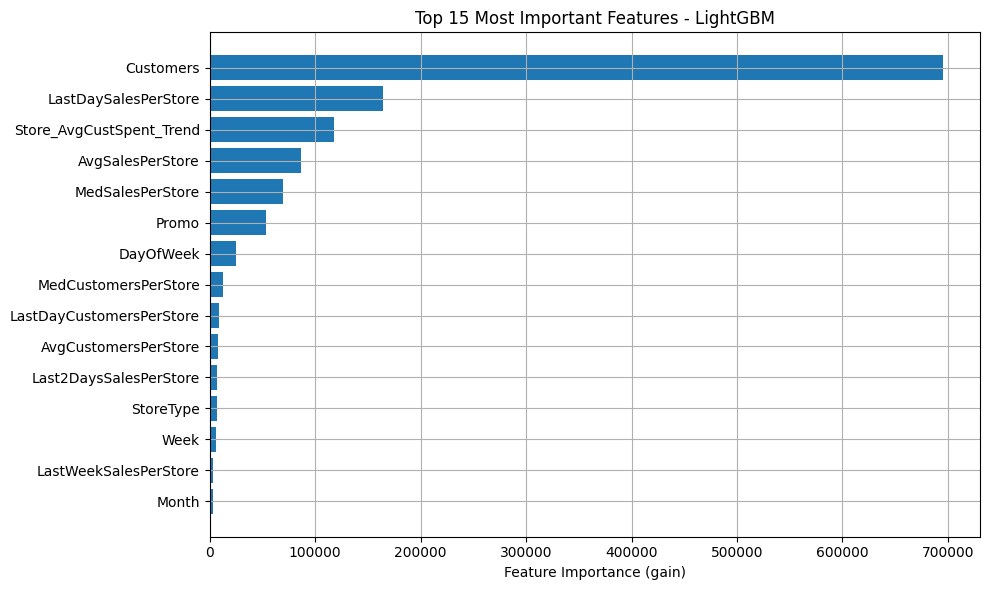

In [52]:
# Feature importance

importance = model_.feature_importance(importance_type='gain')
feature_names = model_.feature_name()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.xlabel("Feature Importance (gain)")
plt.title("Top 15 Most Important Features - LightGBM")
plt.tight_layout()
plt.grid()
plt.show()

In [53]:
# SHAP Values

explainer = shap.TreeExplainer(model_)
shap_values = explainer.shap_values(X_valid)

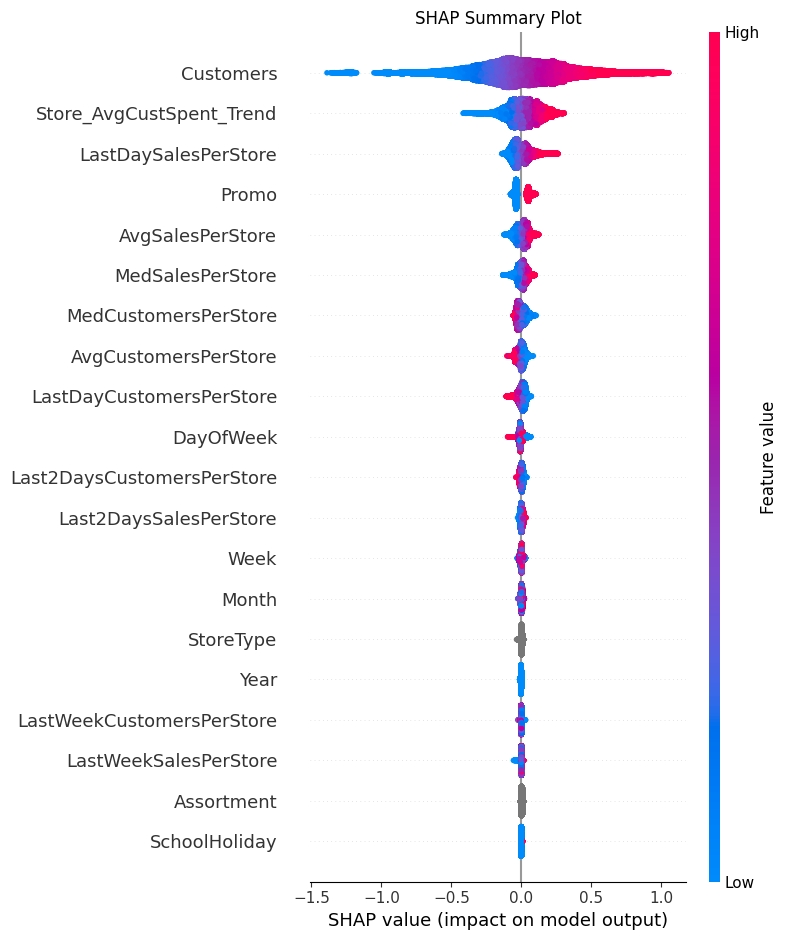

In [54]:
# Summary plot: global interpretability

plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_valid, plot_type="dot", show=False)
plt.show()